In [323]:
import numpy as np
import pandas as pd
import bisect
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [301]:
data = pd.read_csv("fake_job_postings.csv")

In [302]:
data.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

# Unbalanced Data ~ 4.84% fraud

In [303]:
data['fraudulent'].loc[data.fraudulent == 1].count() / data['fraudulent'].count()

0.04843400447427293

# Data Preprocessing

### Potential cleaning to do 
* salary_range: 4 unique dates entered

## Data Engineering

In [304]:
def add_title_flag(df):
    df['title_data_entry'] = [1 if 'entry' in str.lower(title) and 'data' in str.lower(title) 
                              else 0 for title in df.title]
    df['title_home'] = [1 if 'work from home' in str.lower(title) or 'home based' in str.lower(title) 
                        else 0 for title in df.title]
    df['title_dollar'] = [1 if '$' in title else 0 for title in df.title]
    
    return df

In [305]:
data = add_title_flag(data)

## Label Encode Categoricals

In [306]:
# Can't have missing values for label encoder, replace them with 'NaN'
data = data.fillna('NaN')

In [307]:
drop_cols = ['job_id', 'title', 'company_profile', 'description', 'requirements', 'fraudulent']

y = data['fraudulent']
X = data.drop(columns=drop_cols)

In [308]:
X.columns

Index(['location', 'department', 'salary_range', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'title_data_entry', 'title_home', 'title_dollar'],
      dtype='object')

In [309]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [310]:
# for vars like "location" 629 out of 5364 rows in the test set do not appear in train 
# and will be mapped to "<unknown>"

categorical_cols = ['location', 'department', 'salary_range', 
                    'benefits', 'employment_type',
                    'required_experience', 'required_education', 
                    'industry', 'function']

for col in categorical_cols:
    le = LabelEncoder()
    le.fit(X_train[col])

    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '<unknown>')
    le.classes_ = le_classes
    
    X_train[col] = le.transform(X_train[col])
    X_val[col] = X_val[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    X_val[col] = le.transform(X_val[col])


/Users/lisachua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lisachua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lisachua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [312]:
X_train

,location,department,salary_range,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,title_data_entry,title_home,title_dollar
2412,1634,644,705,2409,0,1,0,5,2,4,75,24,0,0,0
10960,2082,644,705,2409,0,1,1,3,7,6,61,24,0,0,0
14273,2082,713,705,2810,0,1,1,1,0,1,61,17,0,0,0
4122,244,644,705,2029,0,1,0,2,6,6,85,23,0,0,0
9578,428,644,310,2409,0,1,0,1,6,6,39,23,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,710,644,129,209,0,1,0,1,2,1,61,29,0,0,0
11964,178,644,705,3765,0,1,1,2,6,6,85,23,0,0,0
5390,1183,644,705,1068,0,1,0,1,0,1,51,32,0,0,0
860,84,164,705,201,0,0,1,2,6,6,85,23,0,0,0


## One-hot Encode Categoricals

X = pd.get_dummies(X, dummy_na=True)
cols = X.columns

len(cols)

# Baseline Model

In [313]:
baseline = RandomForestClassifier(n_estimators=100,random_state=0)
baseline.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [314]:
print("Baseline RF train accuracy: %0.4f" % baseline.score(X_train, y_train))
print("Baseline RF test accuracy: %0.4f" % baseline.score(X_val, y_val))

Baseline RF train accuracy: 0.9991
Baseline RF test accuracy: 0.9786


In [315]:
y_pred = baseline.predict(X_val)

In [316]:
print("Baseline RF test F1 Score: %0.4f" % f1_score(y_val, y_pred))
print("Baseline RF test Weighted F1 Score: %0.4f" % f1_score(y_val, y_pred, average='weighted'))

Baseline RF test F1 Score: 0.7527
Baseline RF test Weighted F1 Score: 0.9769


In [317]:
print("Baseline RF test R2 Score: %0.4f" % r2_score(y_val, y_pred))

Baseline RF test R2 Score: 0.5531


In [318]:
confusion_matrix(y_val, y_pred)

array([[5074,   19],
       [  96,  175]])

# Feature Importance

In [319]:
imp = permutation_importance(baseline, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1)
sorted_idx = imp.importances_mean.argsort()

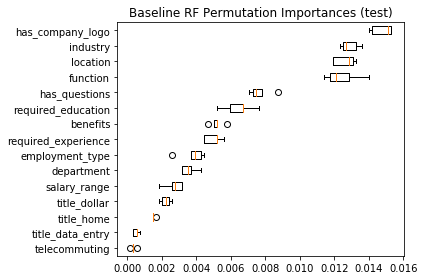

In [328]:
fig, ax = plt.subplots()
ax.boxplot(imp.importances[sorted_idx].T,
           vert=False, labels=X_val.columns[sorted_idx])
ax.set_title("Baseline RF Permutation Importances (test)")
fig.tight_layout()
plt.show()

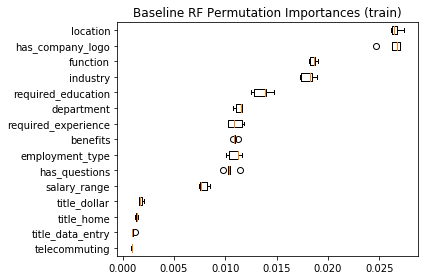

In [329]:
imp2 = permutation_importance(baseline, X_train, y_train, n_repeats=5, random_state=42, n_jobs=-1)
sorted_idx2 = imp2.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(imp2.importances[sorted_idx2].T,
           vert=False, labels=X_val.columns[sorted_idx2])
ax.set_title("Baseline RF Permutation Importances (train)")
fig.tight_layout()
plt.show()